# Making a wind rose with pandas/matplotlib
## Import the libraries and other setup

In [1]:
import pandas
import numpy
import re
import openpyxl
import datetime as dt
import sqlite3
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import decimal
import seaborn

import os
import sys
from matplotlib import pyplot

# SRC_DIR = r'/home/pp/program/jupyter/'
sys.path.append(os.path.dirname(r'/home/pp/program/jupyter/'))
from config import *

# Replace 'your_file.parquet' with the path to your Parquet file
df = pandas.read_parquet(TEPLOTY_SK_DIR + 'teploty_sk.parquet')
tf =df.copy()


seaborn.set_style('ticks')
%matplotlib inline

In [2]:
# dfbrez = df[df.Stanica == 'Brezno']
# maskbrez = df.Stanica == 'Brezno'

# dfbrez = df.loc[maskbrez,['Stanica', 'Smer', 'Rýchlosť', 'Cas_CET']] #OK
dfbrez = df.loc[df.Stanica == 'Bratislava - letisko',['Stanica', 'Smer', 'Rýchlosť', 'Cas_CET']] #OK

directionVocab = {'S': 0, 'SV': 45, 'V': 90, 'JV' : 135, 'J' : 180, 'JZ' : 225,  'Z' : 270, 'SZ' : 315, 'PREM' : 0, 'BEZV' : 0, None : 0}
dfbrez['WindDir'] = dfbrez.Smer.apply(lambda x: directionVocab[x])
dfbrez.rename(columns = {'Rýchlosť' : 'WindSpd'}, inplace=True)
kpdx = dfbrez.loc[:, ['WindSpd', 'WindDir']]

## Load the data

In [3]:
# sta = metar.WeatherStation('KPDX')

windcols = ['WindSpd', 'WindDir']

# sta.getASOSData('2012-01-01', '2015-01-01', filename='wrdemo.csv')
# kpdx = sta.loadCompiledFile('asos', filenum=1).dropna(subset=windcols)

kpdx.WindDir.value_counts()

WindDir
0      4
270    3
90     2
180    1
315    1
135    1
Name: count, dtype: int64

## Determine the total number of observations and how many have calm conditions

In [4]:
total_count = kpdx.shape[0]
calm_count = kpdx.query("WindSpd == 0").shape[0]

print('Of {} total observations, {} have calm winds.'.format(total_count, calm_count))

Of 12 total observations, 0 have calm winds.


## Define a function that will give us nice labels for a wind speed range
E.g., *5 - 10 knots*

In [5]:
def speed_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif numpy.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))

    return list(labels)

### Define a function to convert centered angles to left-edge radians

In [6]:
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * numpy.pi/180. #- numpy.pi/N
    barWidth = 1.8 * numpy.pi / N
    return barDir, barWidth

### Define our bins and labels for speed and wind

In [7]:
spd_bins = [-1, 0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, numpy.inf]
spd_labels = speed_labels(spd_bins, units='m/s')

dir_bins = numpy.arange(-22.5, 370, 45)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

## Determine the relative percentage of observation in each speed and direction bin
Here's how we do it:
  - assign a speed bin for each row with `pandas.cut`
  - assign a direction bin for each row (again, `pandas.cut`)
  - unify the 360° and 0° bins under the 0° label
  - group the data simultaneously on both speed and direction bins
  - compute the size of each group
  - unstack (pivot) the speed bins into columns
  - fill missing values with 0
  - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
  - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
  - convert all of the counts to percentages of the total number of observations

In [8]:
rose = (
    kpdx.assign(WindSpd_bins=lambda df:
            pandas.cut(df['WindSpd'], bins=spd_bins, labels=spd_labels, right=True)
         )
        .assign(WindDir_bins=lambda df:
            pandas.cut(df['WindDir'], bins=dir_bins, labels=dir_labels, right=False)
         )
        .replace({'WindDir_bins': {360: 0}})
        .groupby(by=['WindSpd_bins', 'WindDir_bins'])
        .size()
        .unstack(level='WindSpd_bins')
        .fillna(0)
        .assign(calm=lambda df: calm_count / df.shape[0])
        .sort_index(axis=1)
        .applymap(lambda x: x / total_count * 100)
)

/tmp/ipykernel_5476/1942713440.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(by=['WindSpd_bins', 'WindDir_bins'])
/tmp/ipykernel_5476/1942713440.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: x / total_count * 100)


## Define our wind rose function

In [9]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = seaborn.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = pyplot.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig

##  Use it

/tmp/ipykernel_5476/2305720063.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


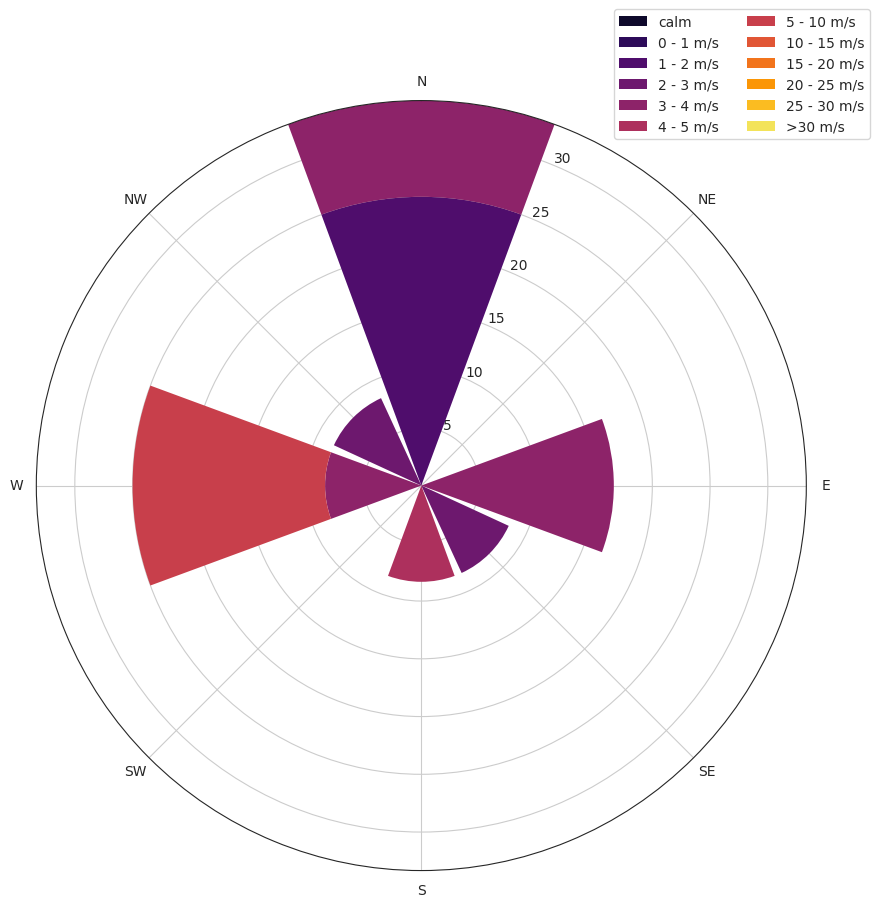

In [10]:
directions = numpy.arange(-0, 360, 45)
fig = wind_rose(rose, directions)

In [11]:
print(dfbrez['Smer'].value_counts())
# numpy.arange(-22.5, 370, 45)
print(sorted(df.Stanica.unique()))


Smer
Z       3
S       2
PREM    2
V       2
J       1
SZ      1
JV      1
Name: count, dtype: int64
['Banská Bystrica - Zelená', 'Banská Štiavnica', 'Bardejov', 'Beluša', 'Boľkovce', 'Bratislava - Koliba', 'Bratislava - Mlynská Dolina', 'Bratislava - letisko', 'Bratislava Ivanka', 'Bratislava Koliba', 'Brezno', 'Bzovík', 'Chopok', 'Dolné Plachtince', 'Donovaly', 'Dudince', 'Gabčíkovo', 'Gánovce', 'Holíč', 'Hurbanovo', 'Jakubovany', 'Jaslovské Bohunice', 'Kamanová', 'Kamenica nad Cirochou', 'Kojsovská hoľa', 'Kojšovská hoľa', 'Košice', 'Košice - Podhradová', 'Košice - letisko', 'Kremnické Bane', 'Kráľova pri Senci', 'Kuchyňa', 'Kuchyňa - Nový Dvor', 'Liesek', 'Liptovská Osada', 'Liptovský Hrádok', 'Liptovský Mikuláš - Ondrašová', 'Lom nad Rimavicou', 'Lomnický štít', 'Lučenec - Boľkovce', 'Malý Javorník', 'Martin - Žabokreky', 'Medzilaborce - Borov', 'Michalovce', 'Milhostov', 'Mochovce', 'Modra - Piesok', 'Moldava nad Bodvou', 'Moravský Svätý Ján', 'Mužla', 'Myjava', 'Málinec', 'Nitra